In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma, poisson, linregress, norm, skew
from scipy.integrate import cumulative_trapezoid, trapezoid
from scipy.special import gammainc
from scipy.special import gamma as gf
from scipy.special import beta as bf
from scipy.special import betaln as lnbf
from scipy.special import betainc as regincbf
import math
import time
import random
import pickle as pkl
from scipy import optimize
import ash
from craterdata import *
%matplotlib inline

In [2]:
area = 10000
synth_list, age = synth_fixed_N(
    N=1000, dmin=10, dmax=1E3, n_points=10000,
    pf=npf_new_loglog,
    n_steps=10000, area=area
)

In [3]:
dmin=10
dmax=20

alpha = np.linspace(1E-5, 10, 10000)

tp_list = []
rr_list = []
combined_list = []

t1 = time.time()
if False:
    for ds in synth_list[:10000]:
    
        tp_rv = truncated_pareto_pdf(ds, dmin=10, dmax=20, alpha=alpha)
        tp_list.append(tp_rv)
        
        rr_rv = rise_over_run_pdf(ds, dmin=dmin, dmax=dmax)
        rr_list.append(rr_rv)
        
        combined_list.append(rr_rv.update(tp_rv))
    with open('saved/truncated_combined_list.pkl', 'wb') as f:
        pkl.dump(combined_list, f)
    with open('saved/truncated_rr_list.pkl', 'wb') as f:
        pkl.dump(rr_list, f)
    with open('saved/truncated_tp_list.pkl', 'wb') as f:
        pkl.dump(tp_list, f)
else:
    with open('saved/truncated_combined_list.pkl', 'rb') as f:
        combined_list = pkl.load(f)
    with open('saved/truncated_rr_list.pkl', 'rb') as f:
        rr_list = pkl.load(f)
    with open('saved/truncated_tp_list.pkl', 'rb') as f:
        tp_list = pkl.load(f)
t2 = time.time()
print(format_runtime(t2 - t1))

0.97152 seconds


In [4]:
tp_means = [rv.mean() for rv in tp_list]
rr_means = [rv.mean() for rv in rr_list]
combined_means = [rv.mean() for rv in combined_list]
print(np.mean(tp_means), np.mean(rr_means), np.mean(combined_means))

0.9316550682606812 1.2061883666971231 1.190460428321046


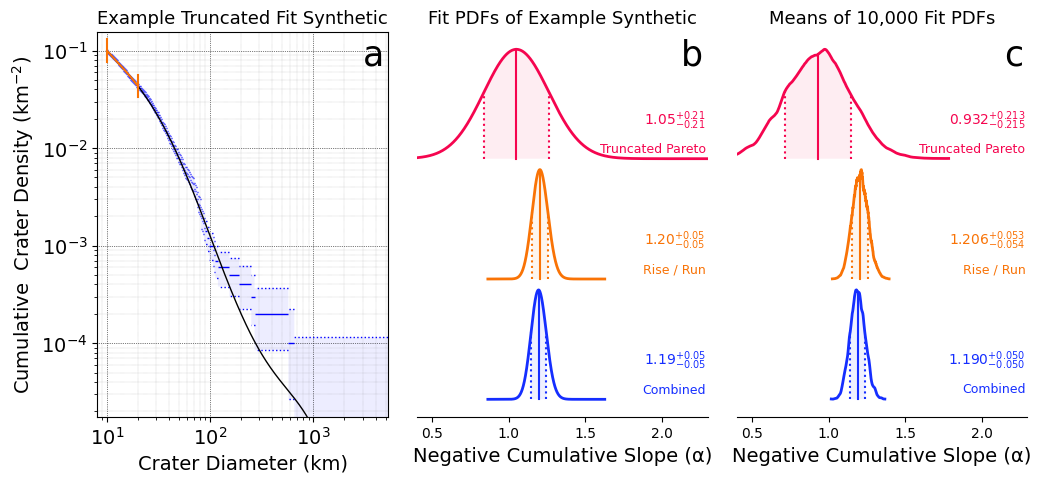

In [5]:
ds = np.loadtxt('../data/example_truncated_synthetic.csv')
    
ds = synth_list[0]

dmin=10
dmax=20

alpha = np.linspace(1E-5, 10, 10000)

alpha_rv = truncated_pareto_pdf(
    ds, alpha=alpha, dmin=dmin, dmax=dmax
)

Nmin = ds[ds >= dmin].shape[0]
Nmax = ds[ds >= dmax].shape[0]
deltaN = Nmin - Nmax
delta_lambda = true_error_pdf(deltaN)
lambda_max = true_error_pdf(Nmax)
linear_rise = delta_lambda / lambda_max + 1
rise = linear_rise.apply(np.log10)
run = np.log10(dmax) - np.log10(dmin)
slope = rise / run 

final_slope = slope.update(alpha_rv)

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(131)
plot_cumulative_unbinned(ds, area, color='blue')
# plt.xlim([8, 50])
# plt.ylim([10**-2.2, 10**-0.8])
X = np.logspace(1, 3.2, 1000)
plt.plot(X, age * npf_new(X), 'k', lw=1)
dmin_high = age * npf_new(dmin) * 1.3
dmin_low = age * npf_new(dmin) / 1.3
dmax_high = age * npf_new(dmax) * 1.3
dmax_low = age * npf_new(dmax) / 1.3
plt.plot([dmin, dmin], [dmin_low, dmin_high], lw=1.5, color=cs[4])
plt.plot([dmax, dmax], [dmax_low, dmax_high], lw=1.5, color=cs[4])
X_interval = X[(X > dmin) & (X < dmax)]
plt.plot(X_interval, age * npf_new(X_interval), color=cs[4], lw=1.5)
plt.title('Example Truncated Fit Synthetic', size=13)

plt.text(
    0.985, 0.985, 'a', transform=plt.gca().transAxes, 
    ha='right', va='top', size=25
)

ax = fig.add_subplot(132)
xlim = [0.4, 2.3]
final_slope.as_kind('linear').plot(
    label=True, xlim=xlim, upshift=0, color=cs[1],
    pdf_label='Combined'
)
slope.as_kind('linear').plot(
    label=True, xlim=xlim, upshift=1.1, color=cs[4],
    pdf_label='Rise / Run'
)
alpha_rv.as_kind('linear').plot(
    label=True, xlim=xlim, upshift=2.2, color=cs[7], 
    pdf_label='Truncated Pareto'
)
npf_rise = np.log10(npf_new(dmin)) - np.log10(npf_new(dmax))
npf_run = np.log10(dmax) - np.log10(dmin)
npf_slope = npf_rise / npf_run

plt.xlabel('Negative Cumulative Slope (α)', size=14)
plt.title('Fit PDFs of Example Synthetic', size=13)

erase_box(ax)
plt.text(
    0.985, 0.985, 'b', transform=plt.gca().transAxes, 
    ha='right', va='top', size=25
)

ax = fig.add_subplot(133)
ash_pdf(combined_means, nbins=30).plot(
    label=True, xlim=xlim, upshift=0, color=cs[1],
    pdf_label='Combined', rounding_n=3
)
ash_pdf(rr_means, nbins=30).plot(
    label=True, xlim=xlim, upshift=1.1, color=cs[4],
    pdf_label='Rise / Run', rounding_n=3
)
ash_pdf(tp_means, nbins=30).plot(
    label=True, xlim=xlim, upshift=2.2, color=cs[7], 
    pdf_label='Truncated Pareto'
)
npf_rise = np.log10(npf_new(dmin)) - np.log10(npf_new(dmax))
npf_run = np.log10(dmax) - np.log10(dmin)
npf_slope = npf_rise / npf_run

plt.xlabel('Negative Cumulative Slope (α)', size=14)
plt.title('Means of 10,000 Fit PDFs', size=13)

erase_box(ax)
plt.text(
    0.985, 0.985, 'c', transform=plt.gca().transAxes, 
    ha='right', va='top', size=25
)

plt.subplots_adjust(wspace=0.1)

pfig = plt.gcf()
pfig.savefig('figs/truncated_synthetic.pdf', bbox_inches='tight')

Calculation of the NPF's slope over the interval.

LinregressResult(slope=-1.1928106020254372, intercept=-4.150641611690469, rvalue=-0.999642429147799, pvalue=0.0, stderr=0.00031910048889293905, intercept_stderr=0.0003681758512024898)

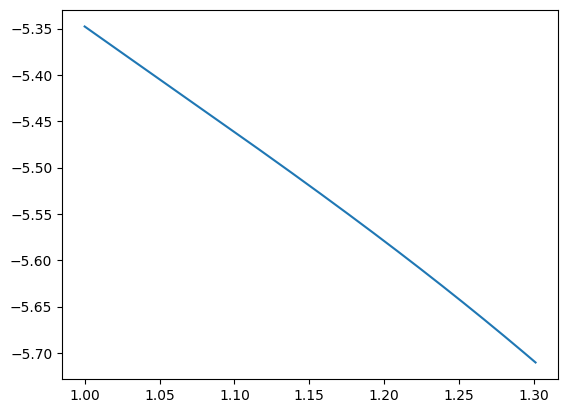

In [6]:
logD = np.linspace(np.log10(dmin), np.log10(dmax), 10000)
logRho = npf_new_loglog(logD)
plt.plot(logD, logRho)
linregress(logD, logRho)

Calculation of the NPF's rise over run slope over the interval.

In [7]:
npf_rise = np.log10(npf_new(dmin)) - np.log10(npf_new(dmax))
npf_run = np.log10(dmax) - np.log10(dmin)
npf_slope = npf_rise / npf_run
npf_slope

1.2047550883928566